In [1]:
suppressPackageStartupMessages({
    library(ArchR)
    library(rhdf5)
    library(parallel)
    library(dplyr)
    library("BSgenome.Mmusculus.UCSC.mm10")
    })


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
addArchRGenome("mm10")
addArchRThreads(threads = 16)

Setting default genome to Mm10.

Setting default number of Parallel threads to 16.



In [3]:
data_name <- 'Ma_2019'

In [4]:
inputFiles <- paste0("/home/siluo/projects/sc_chromatin_benchmark/cleaned_data/Ma_2019", "/GSM4156597_skin.late.anagen.atac.fragments.sorted.bed.gz")
names(inputFiles) <- c(data_name)

In [5]:
# create arrow file
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  minTSS = 0, 
  minFrags = 0, 
  addTileMat = FALSE,
  addGeneScoreMat = FALSE
)

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

ArchR logging to : ArchRLogs/ArchR-createArrows-69f0e77cd1cea-Date-2023-04-03_Time-20-25-33.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

subThreadhing Disabled since ArchRLocking is TRUE see `addArchRLocking`

2023-04-03 20:25:34 : Batch Execution w/ safelapply!, 0 mins elapsed.

(Ma_2019 : 1 of 1) Determining Arrow Method to use!

2023-04-03 20:25:35 : (Ma_2019 : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.002 mins elapsed.

2023-04-03 20:25:35 : (Ma_2019 : 1 of 1) Tabix Bed To Temporary File, 0.002 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", prefix, round(100 * :
“one argument not used by format '%s Reading TabixFile %s Percent'”
2023-04-03 20:28:29 : (Ma_2019 : 1 of 1) Reading TabixFile 10 Percent, 2.915 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", 

In [6]:
# create archR project
projMa_2019 <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "Ma_2019",
  copyArrows = FALSE, #This is recommended so that if you modify the Arrow files you have an original copy for later usage.
  showLogo = FALSE
)

Using GeneAnnotation set by addArchRGenome(Mm10)!

Using GeneAnnotation set by addArchRGenome(Mm10)!

Validating Arrows...

Getting SampleNames...

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...



In [7]:
# add Tile matrix
addTileMatrix(
  input = projMa_2019,
  chromSizes = if (inherits(projMa_2019, "ArchRProject")) getChromSizes(projMa_2019) else NULL,
  blacklist = if (inherits(projMa_2019, "ArchRProject")) getBlacklist(projMa_2019) else NULL,
  tileSize = 500,
  binarize = TRUE,
  excludeChr = c("chrM", "chrY"),
  threads = getArchRThreads(),
  parallelParam = NULL,
  force = TRUE,
  logFile = createLogFile("addTileMatrix")
)

ArchR logging to : ArchRLogs/ArchR-addTileMatrix-69f0e65533178-Date-2023-04-03_Time-21-25-16.log
If there is an issue, please report to github with logFile!

2023-04-03 21:25:17 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-04-03 21:25:25 : Adding TileMatrix to Ma_2019 for Chr (1 of 20)!, 0.115 mins elapsed.

2023-04-03 21:25:57 : Adding TileMatrix to Ma_2019 for Chr (2 of 20)!, 0.635 mins elapsed.

2023-04-03 21:26:26 : Adding TileMatrix to Ma_2019 for Chr (3 of 20)!, 1.122 mins elapsed.

2023-04-03 21:26:48 : Adding TileMatrix to Ma_2019 for Chr (4 of 20)!, 1.501 mins elapsed.

2023-04-03 21:27:15 : Adding TileMatrix to Ma_2019 for Chr (5 of 20)!, 1.949 mins elapsed.

2023-04-03 21:27:38 : Adding TileMatrix to Ma_2019 for Chr (6 of 20)!, 2.322 mins elapsed.

2023-04-03 21:27:58 : Adding TileMatrix to Ma_2019 for Chr (7 of 20)!, 2.657 mins elapsed.

2023-04-03 21:28:21 : Adding TileMatrix to Ma_2019 for Chr (8 of 20)!, 3.047 mins elapsed.

2023-04-03 21:28:41 : Adding TileMa

class: ArchRProject 
outputDirectory: /home/siluo/public/SiyuanLuo/projects/benchmark/scripts/data_cleaning/Ma_2019/Ma_2019 
samples(1): Ma_2019
sampleColData names(1): ArrowFiles
cellColData names(13): Sample TSSEnrichment ... nDiFrags BlacklistRatio
numberOfCells(1): 74692
medianTSS(1): 16.04
medianFrags(1): 3208

In [8]:
saveArchRProject(ArchRProj = projMa_2019, load = FALSE) 

Copying Arrow Files...

Copying Arrow Files (1 of 1)

Saving ArchRProject...



# Per cell QC

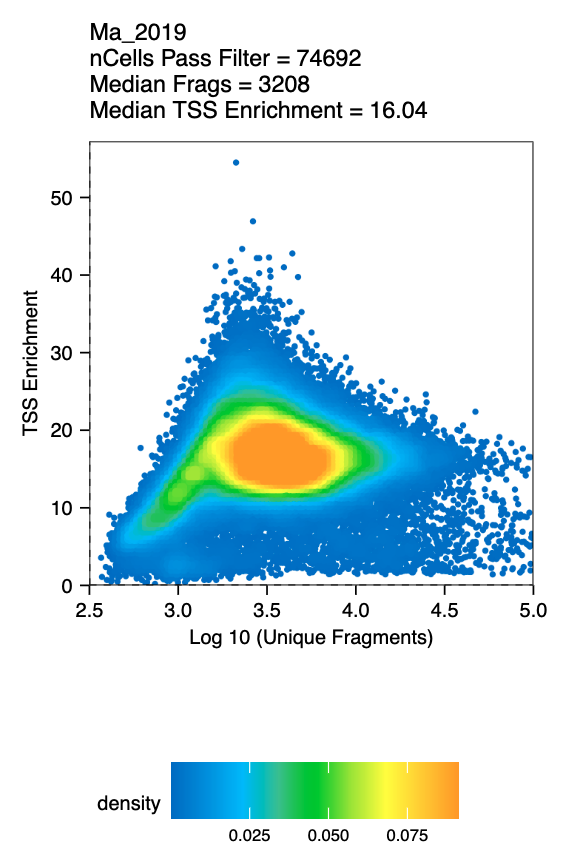

In [14]:
th_tss_min <- 7
th_tss_max <- 35
th_nfrag <- 1000
idxPass1 <- projMa_2019$TSSEnrichment >= th_tss_min
idxPass2 <- projMa_2019$nFrags >= th_nfrag
idxPass3 <- projMa_2019$TSSEnrichment <= th_tss_max
table(data.frame(list("tss"=idxPass1, "nfrags"=idxPass2, "3"=idxPass3)))

, , X3 = FALSE

       nfrags
tss     FALSE  TRUE
  FALSE     0     0
  TRUE      0    81

, , X3 = TRUE

       nfrags
tss     FALSE  TRUE
  FALSE  1537  1814
  TRUE   3709 67551


In [20]:
df2 <- read.table("../../../raw_data/Ma_2019/GSM4156597_skin_celltype.txt", sep="\t", header=TRUE)
head(df2)

,atac.bc,rna.bc,celltype
,<chr>,<chr>,<chr>
1,R1.01.R2.01.R3.06.P1.07,R1.01.R2.01.R3.06.P1.55,Dermal Fibroblast
2,R1.01.R2.03.R3.68.P1.07,R1.01.R2.03.R3.68.P1.55,Dermal Fibroblast
3,R1.01.R2.05.R3.15.P1.05,R1.01.R2.05.R3.15.P1.53,Dermal Fibroblast
4,R1.01.R2.05.R3.40.P1.07,R1.01.R2.05.R3.40.P1.55,Dermal Fibroblast
5,R1.01.R2.05.R3.49.P1.07,R1.01.R2.05.R3.49.P1.55,Dermal Fibroblast
6,R1.01.R2.06.R3.14.P1.07,R1.01.R2.06.R3.14.P1.55,Dermal Fibroblast


In [29]:
Cell_id <- sub('Ma_2019#', '', getCellNames(projMa_2019))
Cell_id <- gsub(',', '.', Cell_id)
Cell_id[1:10]

[1] "R1.30.R2.42.R3.47.P1.04" "R1.06.R2.62.R3.14.P1.04"
 [3] "R1.60.R2.62.R3.57.P1.05" "R1.59.R2.30.R3.29.P1.04"
 [5] "R1.29.R2.92.R3.50.P1.07" "R1.62.R2.15.R3.85.P1.07"
 [7] "R1.69.R2.04.R3.72.P1.07" "R1.47.R2.45.R3.83.P1.06"
 [9] "R1.43.R2.82.R3.04.P1.04" "R1.60.R2.22.R3.11.P1.08"

In [30]:
sum(Cell_id %in% df2$atac.bc)

[1] 34773

In [31]:
sum(Cell_id %in% df2$rna.bc)

[1] 0

In [32]:
sum(Cell_id[idxPass1 & idxPass2 & idxPass3] %in% df2$atac.bc)

[1] 34725

In [34]:
idxPass4 <- Cell_id %in% df2$atac.bc

In [35]:
# Subsetting by per cell QC
cellsPass <- projMa_2019$cellNames[idxPass1 & idxPass2 & idxPass3 & idxPass4]

In [37]:
length(cellsPass)

[1] 34725

In [38]:
projMa_2019.2 <- projMa_2019[cellsPass, ]

In [39]:
# save the project
projMa_2019.2 <- saveArchRProject(ArchRProj = projMa_2019.2, 
                                 outputDirectory = "Ma_2019.2",
                                 load=TRUE) # load=TRUE when one want to overwrite the original files

Copying ArchRProject to new outputDirectory : /home/siluo/public/SiyuanLuo/projects/benchmark/scripts/data_cleaning/Ma_2019/Ma_2019.2

Copying Arrow Files...

Copying Arrow Files (1 of 1)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||  

In [54]:
df_keep <- data.frame(sub('Ma_2019#', '', rownames(getCellColData(projMa_2019.2))))
colnames(df_keep) <- c("cell_id_0")
df_keep$cell_id <- gsub(',', '.', df_keep$cell_id)
rownames(df_keep) <- df_keep$cell_id
head(df_keep)

,cell_id_0,cell_id
,<chr>,<chr>
R1.62.R2.15.R3.85.P1.07,"R1.62,R2.15,R3.85,P1.07",R1.62.R2.15.R3.85.P1.07
R1.60.R2.22.R3.11.P1.08,"R1.60,R2.22,R3.11,P1.08",R1.60.R2.22.R3.11.P1.08
R1.64.R2.44.R3.42.P1.05,"R1.64,R2.44,R3.42,P1.05",R1.64.R2.44.R3.42.P1.05
R1.67.R2.06.R3.63.P1.07,"R1.67,R2.06,R3.63,P1.07",R1.67.R2.06.R3.63.P1.07
R1.84.R2.38.R3.59.P1.07,"R1.84,R2.38,R3.59,P1.07",R1.84.R2.38.R3.59.P1.07
R1.33.R2.21.R3.03.P1.05,"R1.33,R2.21,R3.03,P1.05",R1.33.R2.21.R3.03.P1.05


In [55]:
df3 <- df2[,c("atac.bc", "celltype")]
colnames(df3) <- c("cell_id", "celltype")
head(df3)

,cell_id,celltype
,<chr>,<chr>
1,R1.01.R2.01.R3.06.P1.07,Dermal Fibroblast
2,R1.01.R2.03.R3.68.P1.07,Dermal Fibroblast
3,R1.01.R2.05.R3.15.P1.05,Dermal Fibroblast
4,R1.01.R2.05.R3.40.P1.07,Dermal Fibroblast
5,R1.01.R2.05.R3.49.P1.07,Dermal Fibroblast
6,R1.01.R2.06.R3.14.P1.07,Dermal Fibroblast


In [56]:
df_new <- merge(x = df_keep, y = df3, by = "cell_id")
df_new$celltype <- gsub(" ", "_", df_new$celltype)
head(df_new)

,cell_id,cell_id_0,celltype
,<chr>,<chr>,<chr>
1,R1.01.R2.01.R3.06.P1.07,"R1.01,R2.01,R3.06,P1.07",Dermal_Fibroblast
2,R1.01.R2.01.R3.36.P1.05,"R1.01,R2.01,R3.36,P1.05",Dermal_Papilla
3,R1.01.R2.01.R3.43.P1.08,"R1.01,R2.01,R3.43,P1.08",TAC-1
4,R1.01.R2.02.R3.21.P1.08,"R1.01,R2.02,R3.21,P1.08",IRS
5,R1.01.R2.02.R3.38.P1.08,"R1.01,R2.02,R3.38,P1.08",Basal
6,R1.01.R2.02.R3.53.P1.06,"R1.01,R2.02,R3.53,P1.06",Basal


In [57]:
write.table(df_new$cell_id_0, file='Cells_Ma_2019.txt', sep='\t', quote = FALSE, row.names=FALSE, col.names=FALSE)

In [58]:
write.table(df_new[,c("cell_id_0", "celltype")], file='Ma_2019_RNA_annotation.txt', sep='\t', quote = FALSE, row.names=FALSE, col.names=TRUE)